In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.conv_learner import *

In [3]:
path = Path("data/asian_faces/")

In [4]:
!ls {path}

models tmp    train  valid


In [5]:
f = resnet34
sz = 200

In [21]:
tfms = tfms_from_model(f, sz, aug_tfms=transforms_side_on)
data = ImageClassifierData.from_paths(path, tfms=tfms)

### Check sizes (258,203)

(300, 168)


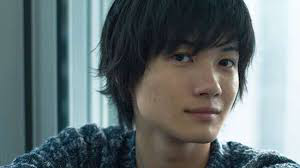

In [76]:
fn = data.trn_ds.fnames[0]
im = PIL.Image.open(path/fn)
print(im.size)
im

In [78]:
sizes = {k: PIL.Image.open(path/k).size for k in data.trn_ds.fnames}
h,w = list(zip(*sizes.values()))

In [80]:
np.mean(h), np.mean(w)

(257.60000000000002, 202.84)

### Training

In [19]:
learn = ConvLearner.pretrained(f, data, ps=0.4, precompute=True)
# increase dropout for less data

In [66]:
lr = 1e-2
lrs = np.array([lr/1000, lr/100, lr])

In [67]:
learn.fit(lr, 3)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy   
    0      0.90783    0.657914   0.5       
    1      0.913826   0.642688   0.666667  
    2      0.853545   0.616106   0.666667  



[0.61610621213912964, 0.66666668653488159]

In [8]:
learn.precompute = False

In [69]:
learn.fit(lr, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                
    0      0.754467   0.621711   0.666667  
    1      0.703732   0.625964   0.666667                
    2      0.674455   0.617788   0.666667  



[0.61778777837753296, 0.66666668653488159]

In [70]:
learn.save('6cycle')

In [9]:
learn.freeze_to(1)

In [72]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                
    0      0.830691   0.601295   0.666667  
    1      0.751309   0.568543   0.666667                
    2      0.744757   0.553208   0.666667                
    3      0.732474   0.535841   0.833333                
    4      0.711682   0.518734   0.666667                
    5      0.677977   0.499747   0.833333                
    6      0.648788   0.490438   0.833333  



[0.49043786525726318, 0.83333331346511841]

In [73]:
learn.save('13cycle-0.49')

In [88]:
learn.load('13cycle-0.49')

In [89]:
learn.fit(lrs, 1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy   
    0      0.679924   0.478194   0.833333  



[0.4781944751739502, 0.83333331346511841]

In [90]:
learn.fit(lrs, 5, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                
    0      0.744714   0.461389   1.0       
    1      0.64869    0.447839   1.0                     
    2      0.612274   0.422751   1.0                     
    3      0.586104   0.419493   1.0                     
    4      0.545711   0.401056   1.0       



[0.40105554461479187, 1.0]

In [91]:
learn.save('19cycle-0.40')

In [92]:
learn.fit(lrs, 6, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                
    0      0.408034   0.390842   1.0       
    1      0.368536   0.39432    1.0                     
    2      0.411476   0.38526    1.0                     
    3      0.407672   0.383255   1.0                     
    4      0.381345   0.37802    1.0                     
    5      0.362172   0.365499   1.0       



[0.36549869179725647, 1.0]

In [93]:
learn.save('25cycle-0.365')

In [10]:
learn.load('25cycle-0.365')

In [51]:
log_preds,y = learn.TTA()
# 6 validation images, each ensembled w/ 4 augmentations, 2 classes => ([5, 6, 2])
probs = np.mean(np.exp(log_preds), axis=0)
# take the exponent of the log and average across the first axis (TTA) to get ensembled predictions => ([6, 2])
accuracy_np(probs,y)

0.83333333333333337

## Confusion Matrix

In [52]:
preds = np.argmax(probs, axis=1)
# returns the index of the largest value, or class prediction
k_probs = probs[:,1]
# validation images predicted to be korean

In [53]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[2 1]
 [0 3]]


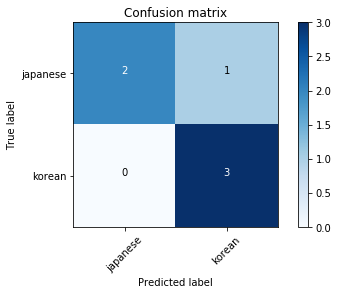

In [55]:
from fastai.plots import *

plot_confusion_matrix(cm, data.classes)

## Look at results

In [65]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 3, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [57]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [62]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(path/ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly classified


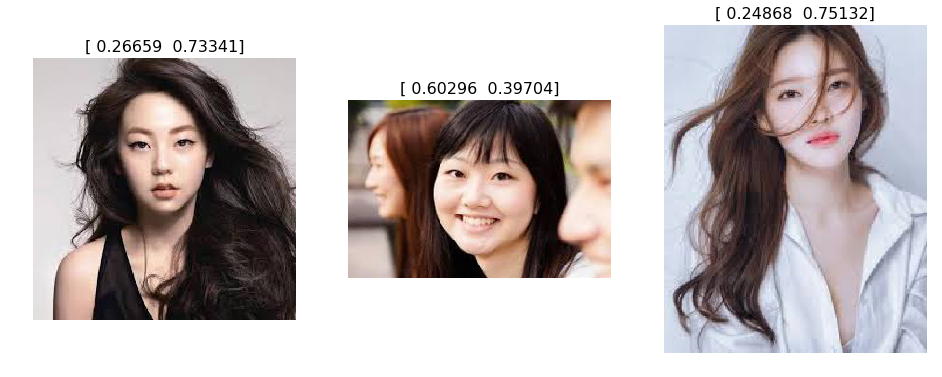

In [63]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


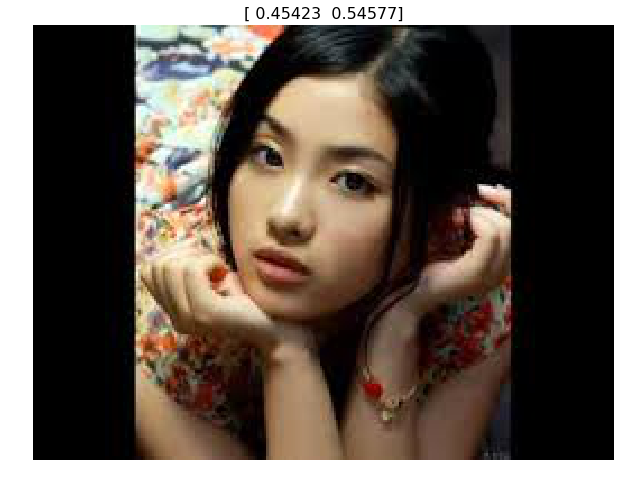

In [66]:
# incorrect 
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")